#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<div> <b>Цель исследования:</b><br>
    1. Построить различные модели предсказания заказов такси <br>
    2. Предсказать колличество заказов на час вперед<br>
    3. Добиться значения RMSE ниже 48<br><br>
    <b>Ход исследования:</b><br>
    1. Загрузка и пердобработка данных<br>
    2. Построение моделей<br>
    3. Пулучение нужного результата и анализ моделей<br>
    </div>

## Подготовка

In [1]:
!pip install prophet

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from catboost import CatBoostRegressor, Pool, cv

import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
print(len(df)/6/24)

184.0


In [6]:
print(df.index[-1] - df.index[0])

183 days 23:50:00


В таблице данные за 184 дня с промежутками по 10 мин.

Ресемплруем данные с интервалом в час.

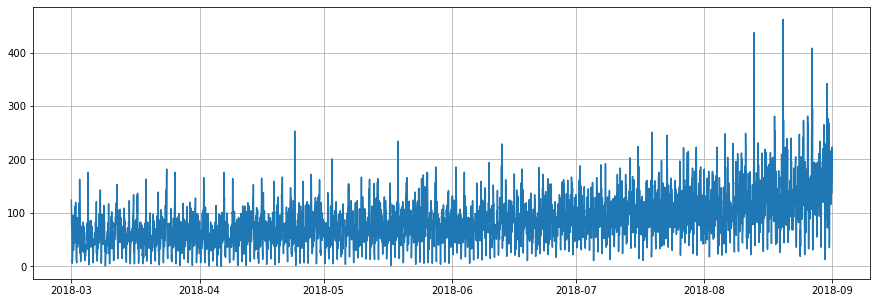

In [7]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
plt.figure(figsize=(15, 5))
plt.plot(df)
#plt.plot(df.rolling(24).mean())
plt.grid(True)

Заметен восходящий тренд.

## Анализ

Декомпозируем данные

In [8]:
def chart(time_data):
    plt.figure(figsize=(15, 5))
    plt.plot(time_data)
    plt.grid(True)
    plt.show()

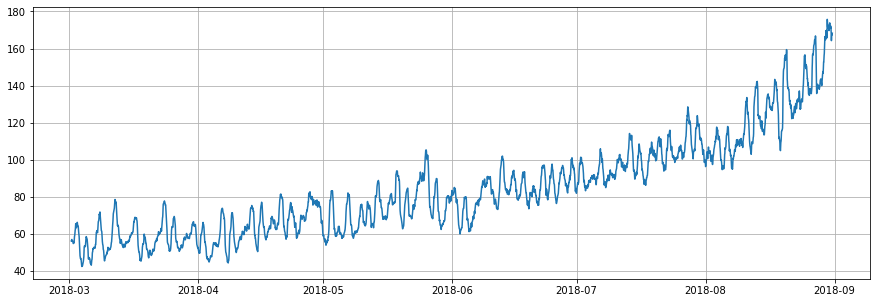

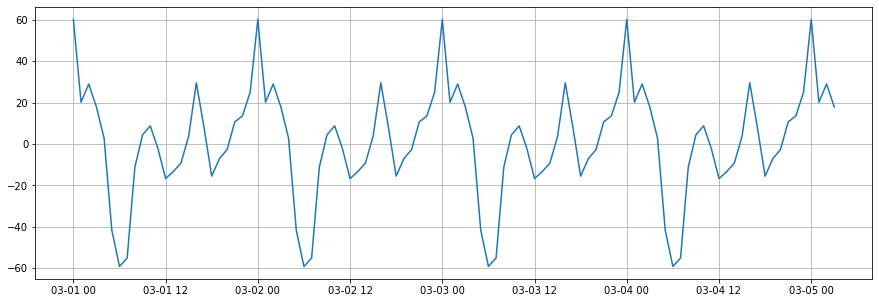

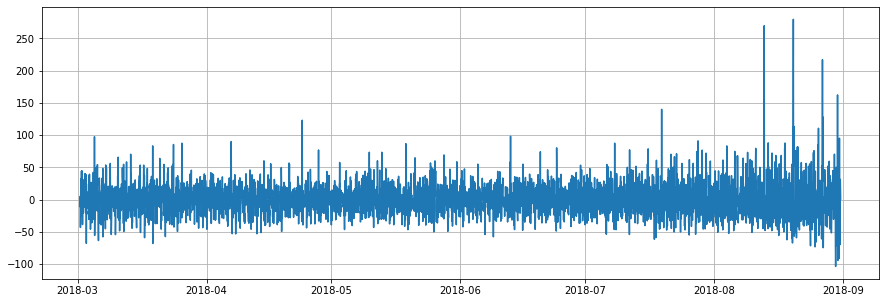

In [9]:
decomposed = seasonal_decompose(df)

chart(decomposed.trend)
chart(decomposed.seasonal[:100])
chart(decomposed.resid)

Заметен восходящий тренд и сезонность с периодом 24 часа. А также небольшое увеличение дисперсии в конце ряда. Ряд не является стационарным.

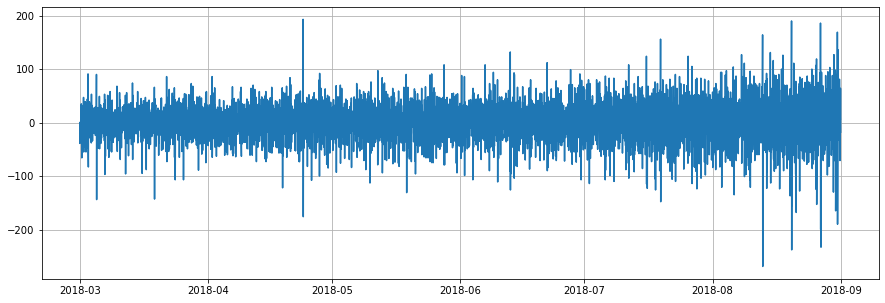

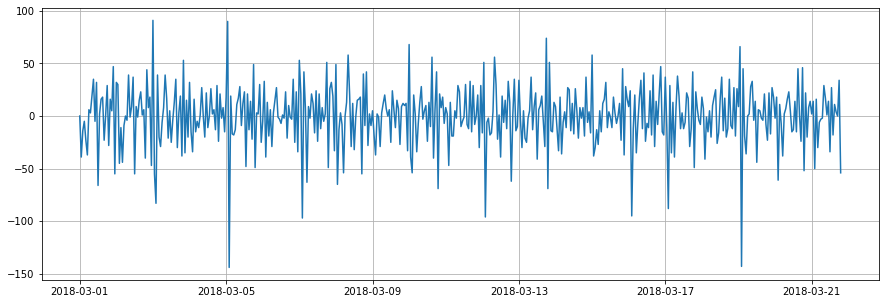

In [10]:
chart((df-df.shift(fill_value=df.iloc[0][0])))
chart((df-df.shift(fill_value=df.iloc[0][0]))[:500])

Первая разность стационарна.

Возьмем 10% данных на тест.

In [11]:
t = len(df)//10

df_test = df[-t:]
df_train = df[:-t]

## Обучение

Т.к. ряд нестационарный, не будем использовать модель RandomForest. Данной моделью можно прогнозировать разность ряда.

Посмотрим на результат prophet

10:13:44 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE train: 23.365853031325635
RMSE test: 34.020156338224794


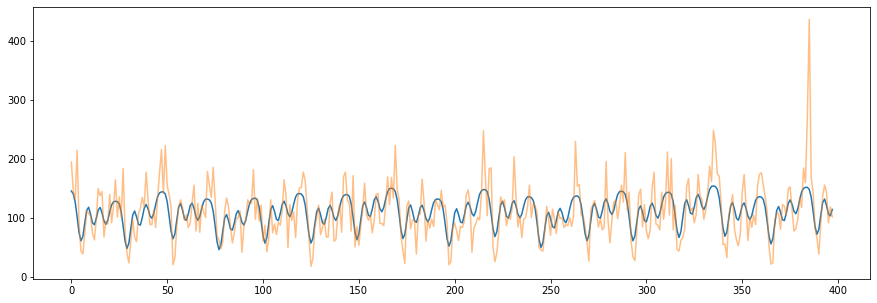

In [27]:
data = df_train.copy()
train, test = train_test_split(data, shuffle=False, test_size=0.1)
t=len(test)

df_prophet = train.reset_index()
df_prophet.columns = ['ds', 'y']
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(freq='H', periods=t)
forecast = m.predict(future)

plt.figure(figsize=(15, 5))
plt.plot(forecast['yhat'].iloc[-t:].reset_index(drop=True))
plt.plot(test.reset_index()['num_orders'], alpha=0.5)
print('RMSE train:',
      mean_squared_error(forecast['yhat'].iloc[:-t].reset_index(drop=True), df_prophet.reset_index()['y'], squared=False))
print('RMSE test:',
      mean_squared_error(forecast['yhat'].iloc[-t:].reset_index(drop=True), test.reset_index()['num_orders'], squared=False))

Попробуем получить результат лучше.

In [13]:
def score_pri(test, t_or_v = 'валидационной'):
    plt.figure(figsize=(15, 5))
    plt.plot(model.predict(test.drop(['num_orders'], axis=1)))
    plt.plot(test['num_orders'].reset_index(drop=True))
    print("RMSE обучающей выборки:", 
      mean_squared_error(model.predict(X), y, squared=False))
    print("RMSE", t_or_v, "выборки: ", 
      mean_squared_error(model.predict(test.drop(['num_orders'], axis=1)), test['num_orders'], squared=False))

Создадим новые признаки:
* календарные признаки (месяц, день, день недели)
* лаги 
* скользящее стреднее за неделю

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Попробуем построить прогноз разными моделями.

### CatBoost

In [17]:
data = df_train.copy()
make_features(data, 500, 24*7)

X = data.drop(['num_orders'], axis=1)
y = data['num_orders']

grid = {'learning_rate': [0.08, 0.1, 0.15],
        'depth': [4, 5, 6],
        'iterations': [100,200]}

tss = TimeSeriesSplit(n_splits=3).split(X)

model = CatBoostRegressor(verbose=100,
                          cat_features=['month', 'day', 'dayofweek'])

model.grid_search(grid, X, y, train_size=0.9, plot=True, cv=tss)
model.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 77.2584387	test: 112.4338688	best: 112.4338688 (0)	total: 26.8ms	remaining: 2.65s
99:	learn: 18.9701134	test: 29.8498228	best: 29.8443415 (98)	total: 2.26s	remaining: 0us

bestTest = 29.84434149
bestIteration = 98

0:	loss: 29.8443415	best: 29.8443415 (0)	total: 2.33s	remaining: 39.6s
0:	learn: 75.8357076	test: 110.7015295	best: 110.7015295 (0)	total: 22ms	remaining: 2.17s
99:	learn: 18.5612014	test: 29.9182309	best: 29.9182309 (99)	total: 2.27s	remaining: 0us

bestTest = 29.91823091
bestIteration = 99

1:	loss: 29.9182309	best: 29.8443415 (0)	total: 4.61s	remaining: 36.9s
0:	learn: 72.2995564	test: 106.3888754	best: 106.3888754 (0)	total: 21.4ms	remaining: 2.12s
99:	learn: 17.5206368	test: 29.8256221	best: 29.8256221 (99)	total: 2.26s	remaining: 0us

bestTest = 29.82562207
bestIteration = 99

2:	loss: 29.8256221	best: 29.8256221 (2)	total: 6.88s	remaining: 34.4s
0:	learn: 77.2326726	test: 112.2943914	best: 112.2943914 (0)	total: 22.5ms	remaining: 4.48s
100:	learn: 18.9382293

{'loss_function': 'RMSE',
 'verbose': 100,
 'cat_features': ['month', 'day', 'dayofweek'],
 'depth': 4,
 'iterations': 200,
 'learning_rate': 0.15}

In [18]:
data = df_train.copy()
make_features(data, 500, 24*7)

train, valid = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X = train.drop(['num_orders'], axis=1)
y = train['num_orders']

model = CatBoostRegressor(verbose=100,
                         depth=4,
                         iterations=200,
                         learning_rate=0.15)
model.fit(X,y, cat_features=['month', 'day', 'dayofweek'])

0:	learn: 33.5391542	total: 22.2ms	remaining: 4.42s
100:	learn: 16.8931381	total: 2.14s	remaining: 2.1s
199:	learn: 14.1452423	total: 4.24s	remaining: 0us


RMSE обучающей выборки: 14.135323960588401
RMSE валидационной выборки:  29.691748709927026


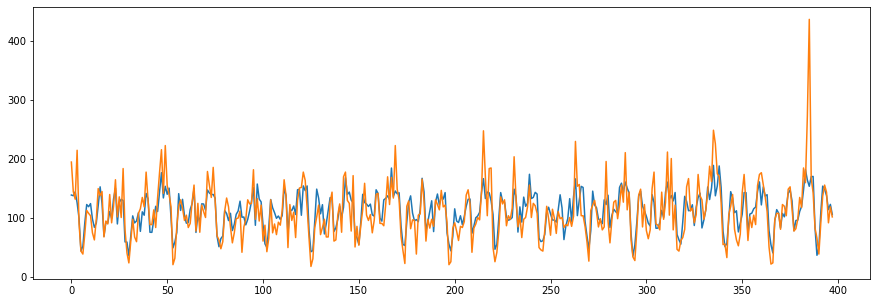

In [19]:
score_pri(test=valid)

Получили неплохой результат, но модель обучается довольно долго.

### LinearRegression

In [20]:
data = df_train.copy()
make_features(data, 500, 24*7)

RMSE обучающей выборки: 18.0717882078676
RMSE валидационной выборки:  29.611079745632615
CPU times: total: 1.08 s
Wall time: 237 ms


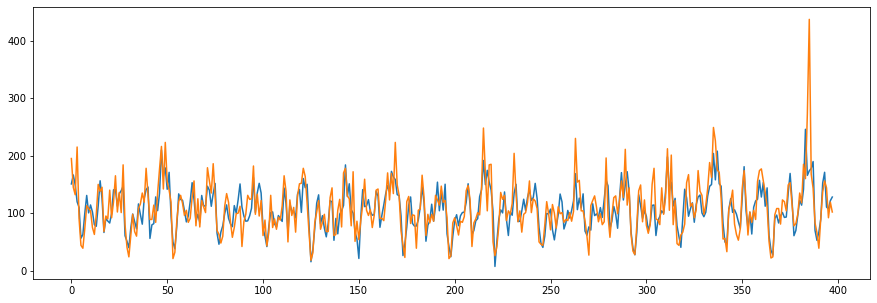

In [21]:
%%time

train, valid = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X = train.drop(['num_orders'], axis=1)
y = train['num_orders']

model = LinearRegression()

model.fit(X,y)

score_pri(test=valid)

Получили такой-же результат что и для CatBoost, но значительно быстрее.

### Прогноз на несколько шагов

Попробуем апроксимировать ряд периодической функцией.

In [22]:
def make_features_fur(data, depth_day=24, depth_week=7):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    data['t'] = ((data.index - datetime(2018, 3, 1)).days * 24  + data.index.hour)
    data['t2'] = data['t']**2
    
    for i in range(1, depth_day+1):
        data['sin_{}'.format(i)] = np.sin(np.pi*i * data['t'] / 12)
        data['cos_{}'.format(i)] = np.cos(np.pi*i * data['t'] / 12)
        data['x_sin_{}'.format(i)] = np.sin(np.pi*i * data['t'] / 12) * data['t']
        data['x_cos_{}'.format(i)] = np.cos(np.pi*i * data['t'] / 12) * data['t']
        data['x2_sin_{}'.format(i)] = np.sin(np.pi*i * data['t'] / 12) * data['t']**1.5
        data['x2_cos_{}'.format(i)] = np.cos(np.pi*i * data['t'] / 12) * data['t']**1.5
    for i in range(1, depth_week+1):
        data['sin_week{}'.format(i)] = np.sin(np.pi*i * data['dayofweek'] / 7 * 2)
        data['cos_week{}'.format(i)] = np.cos(np.pi*i * data['dayofweek'] / 7 * 2)

In [23]:
rmse = 48

for d in range(1,25):
    data = df_train.copy()
    make_features_fur(data, d, 7)

    train, valid = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    X = train.drop(['num_orders'], axis=1)
    y = train['num_orders']

    model_grid = LinearRegression()

    model_grid.fit(X,y)
    
    if mean_squared_error(model_grid.predict(valid.drop(['num_orders'], axis=1)), valid['num_orders'], squared=False) < rmse:
        rmse = mean_squared_error(model_grid.predict(valid.drop(['num_orders'], axis=1)), valid['num_orders'], squared=False)
        model = model_grid
        per = d
        
print(per, rmse)


11 31.09414507197753


RMSE обучающей выборки: 20.553958523432314
RMSE валидационной выборки:  31.09414507197753


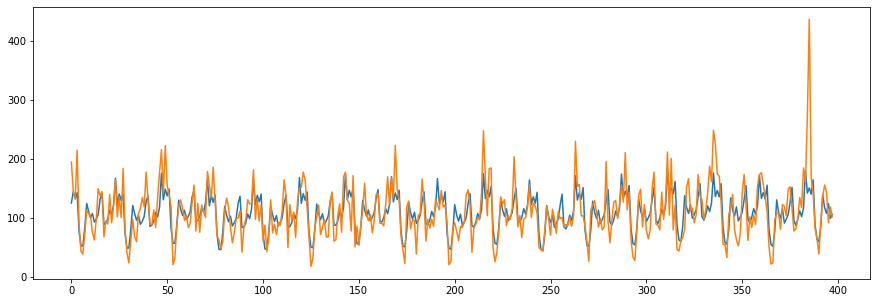

In [24]:
data = df_train.copy()
make_features_fur(data, 11, 7)

train, valid = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X = train.drop(['num_orders'], axis=1)
y = train['num_orders']

model = LinearRegression()

model.fit(X,y)

score_pri(test=valid)

Получили результат немного хуже чем для предыдущих случаев, но зато горизонт прогнозирования не ограничен.

## Тестирование

Проведем тест на более быстрой модели.

RMSE обучающей выборки: 19.178406535872856
RMSE тестовой выборки:  36.722633407018265


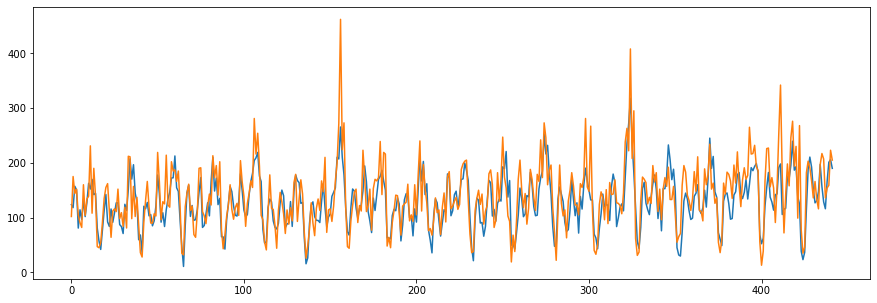

In [25]:
data = df.copy()
make_features(data, 500, 24*7)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X = train.drop(['num_orders'], axis=1)
y = train['num_orders']

model = LinearRegression()

model.fit(X,y)

score_pri(test=test, t_or_v='тестовой')

Требуемая точность достигнута.

## Вывод

Дан временной ряд с данными о заказах такси в аэропортах с шагом в 10 минут. Ресемплировали данные с интервалом в час. Декомпозировали получившийся ряд, он оказался не стационарным с восходящим трендом. Построили две модели регрессии(LinearRegression и CatBoost). Модели показали близкие результаты, но линейная регрессия работает быстрее. Также построили модель предсказания с большим горизонтом, получили результат хуже чем для других моделей, тем не мение данная модель может быть полезна при длительных прогнозах. На тесте модель линейной регрессии показала точность удовлетворяющую поставленой задаче.